In [1]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import numpy as np

/home/aso/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


/home/aso/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/aso/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Input size: torch.Size([2, 3, 448, 448])


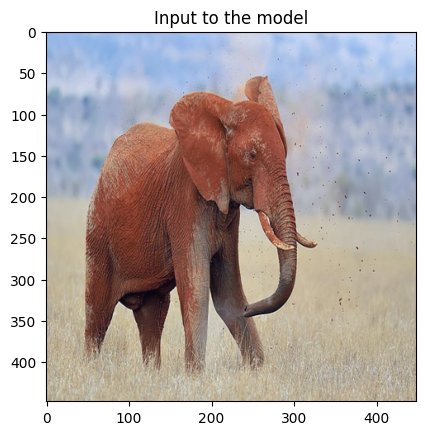

In [2]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image1 = Image.open('elephant_1.jpg')
image2 = Image.open('elephant_2.jpg')

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
model = AutoModel.from_pretrained('facebook/dinov2-large')

inputs = processor(images=[image1, image2], return_tensors="pt", size={"height": 448, "width": 448}, do_center_crop=False)
print('Input size:', inputs['pixel_values'].shape)

# Min-max scaled input to the model
plt.imshow(minmax_scale(inputs['pixel_values'][0].permute(1, 2, 0).numpy().ravel()).reshape(448, 448, 3))
plt.title("Input to the model")
plt.show()


outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

# We have to force return_dict=False for tracing
# model.config.return_dict = False

# with torch.no_grad():
#     traced_model = torch.jit.trace(model, [inputs.pixel_values])
#     traced_outputs = traced_model(inputs.pixel_values)

# print((last_hidden_states - traced_outputs[0]).abs().max())

In [3]:
last_hidden_state = outputs.last_hidden_state # (B, Ntok, D)
pooler_output = outputs.pooler_output # (B, D)
hidden_states = outputs.hidden_states # 13 layers, each with (B, Ntok, D)
attentions = outputs.attentions # 12 layers, each with (B, H, Ntok, Ntok)

print("Last hiddens state size", last_hidden_state.shape)

Last hiddens state size torch.Size([2, 1025, 1024])


In [20]:
# B = 1
# Ntokens = 256
# CLS token = 1
# Layers = 12
# Heads = 12
# model.config

### Visualizations

(4096, 1024)


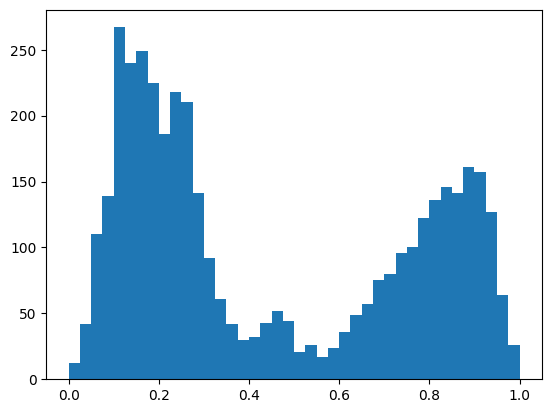

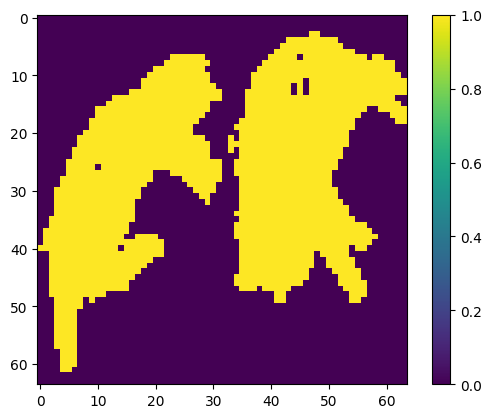

In [183]:
patch_features = last_hidden_state
fg_pca = PCA(1)
all_patches = patch_features[:, 1:].flatten(0, 1).detach().numpy()
print(all_patches.shape)
reduced_patches = fg_pca.fit_transform(all_patches)
norm_patches = minmax_scale(reduced_patches)
# projected_features = fg_pca.fit_transform(patch_features; norm_features = sklearn.processing.minmax_scale(projected_patches)
plt.hist(norm_patches, bins=40)
plt.show()
threshold = 0.5
mask = norm_patches > threshold

plt.figure()
plt.imshow(mask.reshape(64, 64, 1))
plt.colorbar()
plt.show()

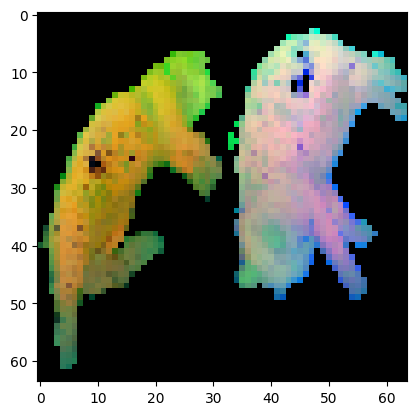

In [184]:
patch_features
# patches_rgb = minmax_scale(PCA(3).fit_transform(patch_features[0, 1:].detach().numpy()))
patches_rgb = minmax_scale(PCA(3).fit_transform(patch_features[0, 1:].detach().numpy())[mask.squeeze()])

feats_rgb = np.zeros((64, 64, 3))
feats_rgb[mask.reshape(64, 64)] = patches_rgb
plt.imshow(feats_rgb)

(896, 896, 3)


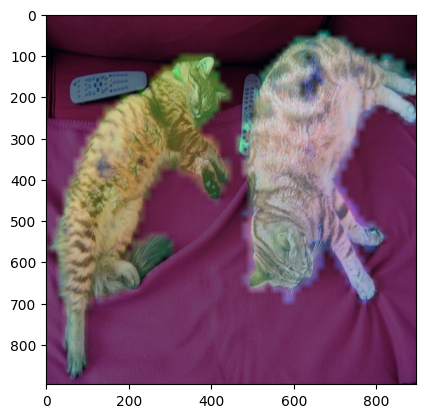

In [185]:
from skimage.transform import rescale, resize, downscale_local_mean
feats_rescaled = resize(feats_rgb, (896, 896), anti_aliasing=True)
print(feats_rescaled.shape)

plt.imshow(minmax_scale(inputs['pixel_values'][0].permute(1, 2, 0).numpy().ravel()).reshape(896, 896, 3))
plt.imshow(feats_rescaled, alpha=0.5)

### Visualization across different images

In [243]:
patch_features = last_hidden_state # (B, Ntok, D)
fg_pca = PCA(1)

B = patch_features.shape[0]
masks = []
thresholds = [0.59, 0.6]

for b in range(B):
    all_patches = patch_features[b, 1:].detach().numpy()
    reduced_patches = fg_pca.fit_transform(all_patches)
    norm_patches = minmax_scale(reduced_patches)
    # plt.figure()
    # plt.hist(norm_patches, bins=40)
    threshold = thresholds[b]
    masks.append(norm_patches > threshold)
    # plt.figure()
    # plt.imshow((norm_patches > threshold).reshape(32, 32))

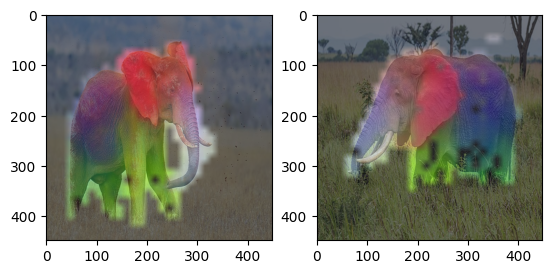

In [244]:
pca_rgb = PCA(3)
all_fg_patches = torch.concat([patch_features[i, 1:][masks[i].squeeze()] for i in range(B)], axis=0)
fg_patch_counts = [mask.sum() for mask in masks]
fg_patch_cumsum = np.cumsum(fg_patch_counts)
fg_patches_rgb = minmax_scale(pca_rgb.fit_transform(all_fg_patches.detach().numpy()))
feats_rgb = np.zeros((B, 32, 32, 3))
for b in range(B):
    if b == 0:
        feats_rgb[b][masks[b].reshape(32, 32)] = fg_patches_rgb[:fg_patch_cumsum[b]]
    elif b == B-1:
        feats_rgb[b][masks[b].reshape(32, 32)] = fg_patches_rgb[fg_patch_cumsum[b-1]:]
    else:
        feats_rgb[b][masks[b].reshape(32, 32)] = fg_patches_rgb[fg_patch_cumsum[b-1]: fg_patch_cumsum[b]]

fig, axs = plt.subplots(1, B)
for b in range(B):
    feats_rescaled = resize(feats_rgb[b], (448, 448), anti_aliasing=True)
    axs[b].imshow(minmax_scale(inputs['pixel_values'][b].permute(1, 2, 0).numpy().ravel()).reshape(448, 448, 3))
    axs[b].imshow(feats_rescaled, alpha=0.5)
plt.show()

### Token norm inspection

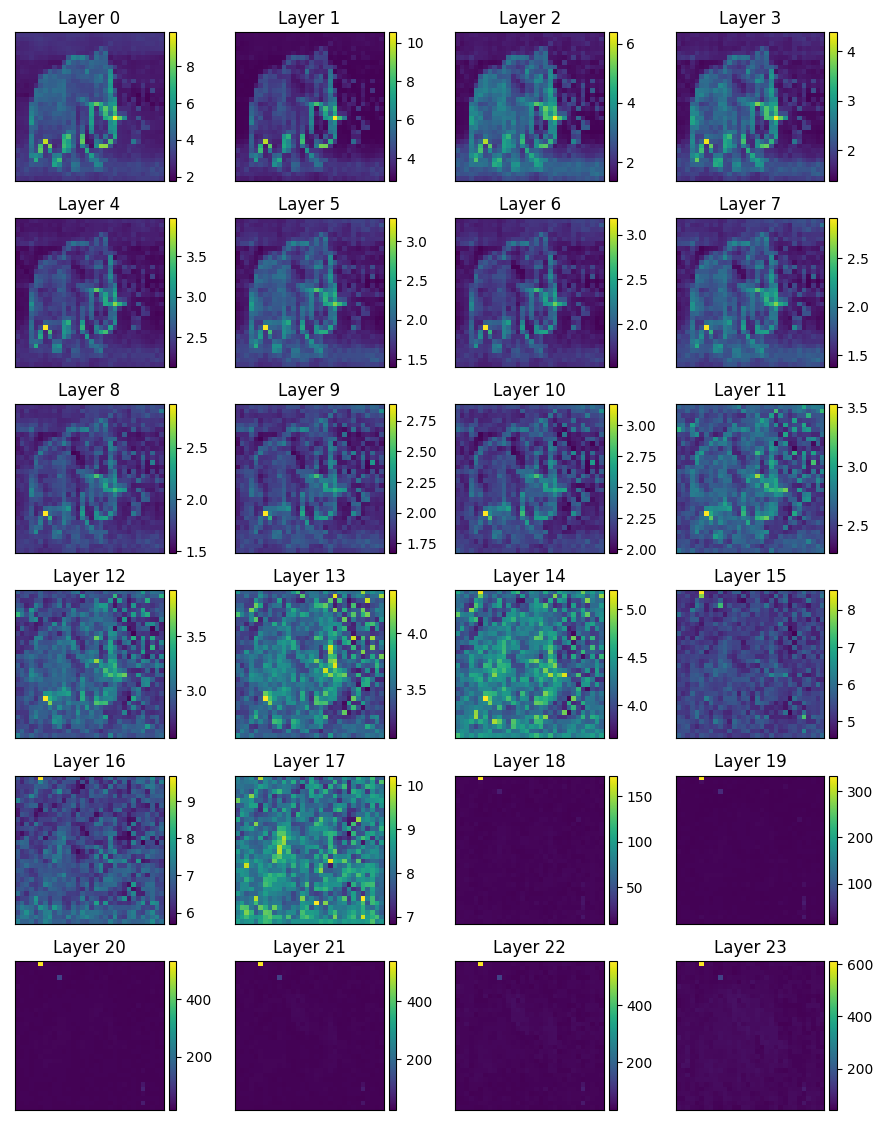

In [115]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps

my_cmap = 'viridis'
fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(11, 14))
for i in range(6):
    for j in range(4):
        l = 4*i + j
        norms = hidden_states[l][0, 1:].view(32, 32, -1).norm(dim=-1)
        im = axs[i, j].imshow(norms.detach().numpy(), cmap=my_cmap)
        axs[i, j].set_title(f"Layer {l}")
        divider = make_axes_locatable(axs[i, j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical', cmap=my_cmap)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

    
plt.subplots_adjust(hspace=0.25, wspace=0.15)

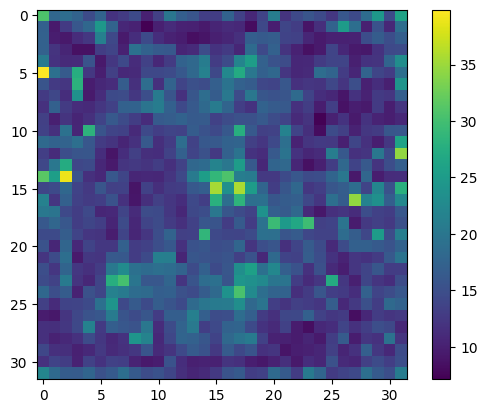

In [54]:
b = 0
h = 5
plt.imshow(attentions[11][b].sum(-2)[:, 1:].reshape(16, 32, 32).sum(0).detach().numpy())
plt.colorbar()